# Introduction



Having a finance background, I always look forward to gain deep insights into business and have the potential to do something impactful. This mindset drove me to pursue the data science diploma at BrainStation and formulated my capstone question of whether or not we can predict a user is going to churn from an online platform.

I focus on mobile gaming industry because, competition for users is getting more and more fierce. It is extremely important to retain as many acquired customers as possible.
The goal of the project is to predict if a user is going to leave a mobile game based on the historical data such as the time user spent on platform, and some other gamers attributes as well as in app purchase records. The game is LengBear - a social casino game - exclusively published in Cambodia. 

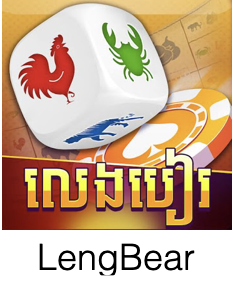

Data can be accessed from this google drive links below. The "play log" contains the records of users active session. There are 9 mini games inside the app "Lengbear", an social casino games made and publish exclusively for Cambodia. The transactions log is the records of user in app purchase.

play log file url: https://drive.google.com/file/d/10urw6q7ahacPIYImSeSHCRhrGb5eCZ60/view?usp=sharing

transaction url: https://drive.google.com/file/d/1zVAIiW5jjFwbcFOAr6ey4r4FdRaDVzoB/view?usp=sharing

Lengbear game url: https://play.google.com/store/apps/details?id=leng.bear.free.cm&hl=en_CA

In this project I will first create features from user play log from t0 to t4 and fit the data into several models namely: Logistic Regression, Random Forrest and Multilayer Percepton Classifier to predict if a user is going to churn or not on t5. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

## Transaction Log

The transaction log is from 2020-03-01 to 2020-05-13, consists 342,544 unique entries. I will first examines the data and see what insights can be gained from this data. 

In [2]:
# Load the transactions log data
transactions_df=pd.read_csv('data/transactions.csv', index_col=0, infer_datetime_format=True)
transactions_df.head()

,UserID,Amount,Chips,Date,Channel
0,4403840,0.5,600000,2020-03-04 00:00:09.270,DCB_Smart_Axiata
1,4209368,1.0,2000000,2020-03-04 00:01:07.777,Wing
2,4627993,0.2,200000,2020-03-04 00:01:15.257,DCB_Smart_Axiata
3,4689823,0.2,200000,2020-03-04 00:01:53.540,DCB_Smart_Axiata
4,5209800,0.2,200000,2020-03-04 00:02:11.197,DCB_Smart_Axiata


In [3]:
# Check if there is any missing values
transactions_df.isna().sum()

UserID     0
Amount     0
Chips      0
Date       0
Channel    0
dtype: int64

In [4]:
# Inspect the columns and datatype
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342544 entries, 0 to 342543
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   UserID   342544 non-null  int64  
 1   Amount   342544 non-null  float64
 2   Chips    342544 non-null  int64  
 3   Date     342544 non-null  object 
 4   Channel  342544 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 15.7+ MB


In [5]:
# Slice away the purchasing time for date in transaction data
transactions_df['Date']=pd.to_datetime(transactions_df['Date'].str[:10])
transactions_df.head()

,UserID,Amount,Chips,Date,Channel
0,4403840,0.5,600000,2020-03-04,DCB_Smart_Axiata
1,4209368,1.0,2000000,2020-03-04,Wing
2,4627993,0.2,200000,2020-03-04,DCB_Smart_Axiata
3,4689823,0.2,200000,2020-03-04,DCB_Smart_Axiata
4,5209800,0.2,200000,2020-03-04,DCB_Smart_Axiata


### Overview of sales trend

In general, sales have been slowing down since people got into lockdown for Covid-19.

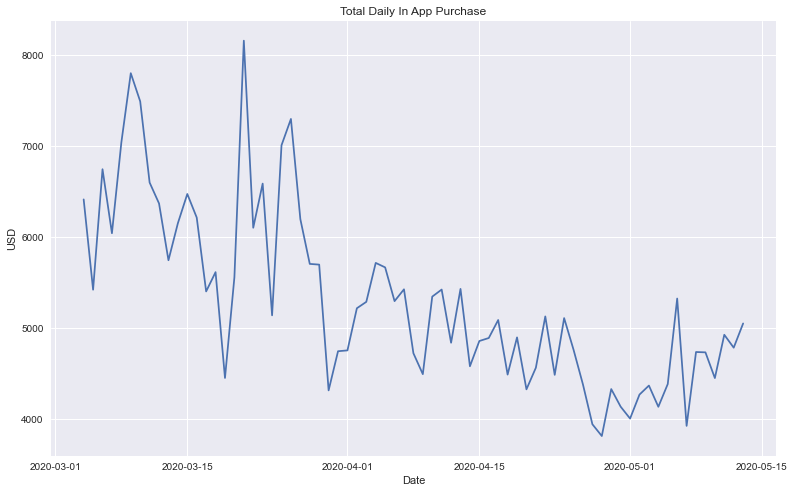

In [6]:
# Calculate sales by day
transactions_df_sum=pd.DataFrame(transactions_df.groupby('Date').sum()['Amount']).reset_index()
transactions_df_sum['Day']=pd.to_datetime(transactions_df_sum['Date']).dt.day_name()

# Visualize sales by day of the period
plt.figure(figsize=(13,8))
sns.lineplot(transactions_df_sum['Date'], transactions_df_sum['Amount'], sizes=(13,8))
plt.ylabel('USD')
plt.title('Total Daily In App Purchase')
plt.savefig('IAP by data.png', dpi=400)
plt.show()

### Sales generated on day of the week

The data on hand shows that in general, Saturday is the time people buys the most. Friday sales are usually lower, possibly because users hang out during Friday night and staying indoor to play game on Saturday. Sunday seems to generate less playing time too as people are prepare for the new working week. 

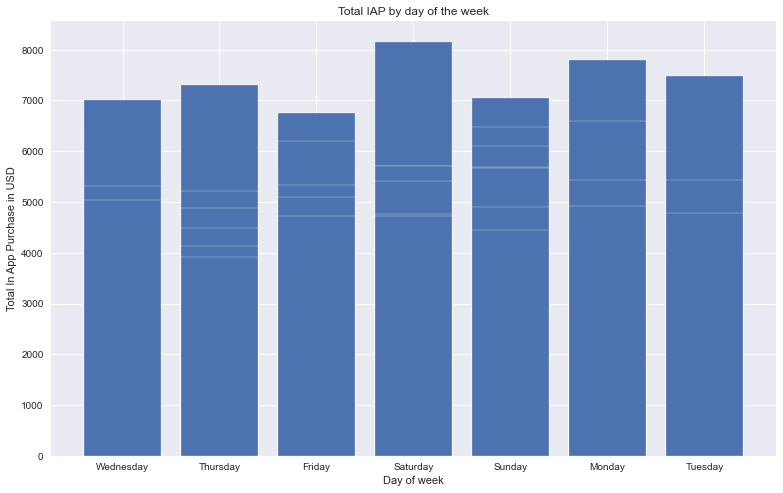

In [7]:
# Visualize sales by day of week 
plt.figure(figsize=(13,8))
plt.bar(transactions_df_sum['Day'], transactions_df_sum['Amount'])
plt.xlabel('Day of week')
plt.ylabel('Total In App Purchase in USD')
plt.title('Total IAP by day of the week')
plt.savefig('Total IAP by day of the week.png', dpi=400)
plt.show()

### Popularity of payment channels

The most popular payment channels that users use to buy in-app items are through the use of direct carrier billing with Smart Telecommunication and the second most popular is Wing (an e-wallet company). While Direct Carrier Billing with Smart is the most popular, the average transaction size is the smallest. This shows that majority of the users use Smart as their mobile service provider. In general, e-wallets such as Wing, Asia, and Pipay has much higher average transaction size. 

In [8]:
# Count the Amount generated by each in app purchase channel and the number of use
transactions_iap_by_channels=transactions_df.groupby('Channel').sum()['Amount'].reset_index()
transactions_iap_by_channels['Use_Count']=transactions_iap_by_channels['Channel'].map(transactions_df['Channel'].value_counts())
transactions_iap_by_channels['Average_Transaction_in_$']=transactions_iap_by_channels['Amount']/transactions_iap_by_channels['Use_Count']
transactions_iap_by_channels=transactions_iap_by_channels.sort_values('Amount', ascending=False).set_index('Channel')
transactions_iap_by_channels

,Amount,Use_Count,Average_Transaction_in_$
Channel,,,
DCB_Smart_Axiata,162931.61,226264,0.720095
Wing,114243.00,35917,3.180750
DCB_Cellcard_Coda,65953.20,70179,0.939785
Wing_Local,25946.59,5712,4.542470
DCB_Metfone_Coda,3277.50,2941,1.114417
Asia,2886.00,1052,2.743346
Pipay,1592.00,478,3.330544
DCB_Unitel,0.23,1,0.230000


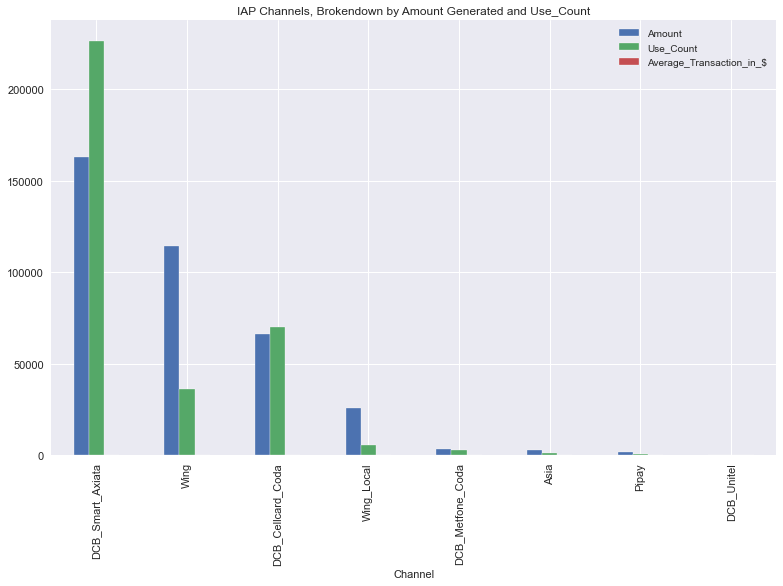

In [9]:
# Plot IAP Channels, brokendown by amount generated and Use_Count
fig=transactions_iap_by_channels.plot(kind='bar', figsize=(13,8), fontsize=11, title='IAP Channels, Brokendown by Amount Generated and Use_Count').get_figure()
fig.savefig('IAP Channels, brokendown by amount generated and Use_Count.pdf', dpi=400)

## Play Log Data

The play log is generated from 2020-05-01 to 2020-05-13. Each line is an online playing session of an unique UserID with an unique GameID and unique Betting Level. There are 1,768,640 rows and 12 columns in the data. 


In [10]:
# Load the play log file and check if there is any missing values
play_log_df=pd.read_csv('data/playlog01-130520.csv', index_col=0)
play_log_df.head()

/Users/Ben/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Sequence,UserID,GameID,Level,WinNo,DrawNo,LostNo,WinAmt,LostAmt,Date,Currency_Type1,Currency_Type2
0,50518638,5894561,9009,1000,0,0,1,0,24964,2020-05-09 00:00:00.000,0,0
1,50518637,6047531,9009,20,2,0,0,515,0,2020-05-09 00:00:00.000,0,0
2,50518636,4972744,9009,100,1,0,3,1748,7800,2020-05-09 00:00:00.000,0,0
3,50518635,5608136,9009,1000,9,0,15,128680,137000,2020-05-09 00:00:00.000,0,0
4,50518634,4725768,9009,100,10,0,34,18272,27100,2020-05-09 00:00:00.000,0,0


In [11]:
# Check missing value
play_log_df.isna().sum()

Sequence          0
UserID            0
GameID            0
Level             0
WinNo             0
DrawNo            0
LostNo            0
WinAmt            0
LostAmt           0
Date              0
Currency_Type1    0
Currency_Type2    0
dtype: int64

In [12]:
# Review play_log data frame
play_log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1768640 entries, 0 to 1768639
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Sequence        int64 
 1   UserID          int64 
 2   GameID          int64 
 3   Level           int64 
 4   WinNo           int64 
 5   DrawNo          int64 
 6   LostNo          int64 
 7   WinAmt          int64 
 8   LostAmt         int64 
 9   Date            object
 10  Currency_Type1  int64 
 11  Currency_Type2  int64 
dtypes: int64(11), object(1)
memory usage: 175.4+ MB


In [13]:
# Further reviewing data in each column
play_log_df.describe()

,Sequence,UserID,GameID,Level,WinNo,DrawNo,LostNo,WinAmt,LostAmt,Currency_Type1,Currency_Type2
count,1.768640e+06,1.768640e+06,1.768640e+06,1.768640e+06,1.768640e+06,1768640.0,1.768640e+06,1.768640e+06,1.768640e+06,1768640.0,1768640.0
mean,5.028838e+07,5.173211e+06,8.710541e+03,7.668269e+03,5.716449e+00,0.0,1.188716e+01,5.630973e+05,6.238427e+05,0.0,0.0
std,5.105625e+05,1.269449e+06,1.509552e+03,6.928382e+04,1.421466e+01,0.0,4.580591e+01,9.817862e+06,1.018438e+07,0.0,0.0
min,4.940406e+07,1.230000e+02,1.008000e+03,2.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,4.984622e+07,4.952213e+06,9.002000e+03,1.000000e+02,0.000000e+00,0.0,2.000000e+00,0.000000e+00,1.240000e+03,0.0,0.0
50%,5.028838e+07,5.776227e+06,9.009000e+03,1.000000e+02,2.000000e+00,0.0,4.000000e+00,1.855000e+03,7.000000e+03,0.0,0.0
75%,5.073054e+07,5.972449e+06,9.009000e+03,1.000000e+03,6.000000e+00,0.0,1.000000e+01,2.226425e+04,3.971025e+04,0.0,0.0
max,5.117270e+07,6.104168e+06,9.009000e+03,1.000000e+07,1.383000e+03,0.0,6.482000e+03,2.525479e+09,2.567000e+09,0.0,0.0


In [14]:
# Remove redundant columns namely: Sequence, DrawNo, Currency_Type1, Currency_Type2 since they are all 0 and set the time to regular format
play_log_df.drop(['Sequence', 'DrawNo', 'Currency_Type1', 'Currency_Type2'], axis=1, inplace=True)
play_log_df['Date']=pd.to_datetime(play_log_df['Date'].str[:10])
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date
0,5894561,9009,1000,0,1,0,24964,2020-05-09
1,6047531,9009,20,2,0,515,0,2020-05-09
2,4972744,9009,100,1,3,1748,7800,2020-05-09
3,5608136,9009,1000,9,15,128680,137000,2020-05-09
4,4725768,9009,100,10,34,18272,27100,2020-05-09


In [15]:
# Making the dataframe for GameID and Match_Length in seconds (data provided by game owner)
# Gamename BINH                9001: 80 seconds
# Gamename POKDENG             9002: 80 seconds
# Gamename BAUCUA              9005: 20 seconds
# Gamename SHOW                9004: 80 seconds
# Gamename XOCDIA              9003: 20 seconds
# Gamename SIKU                9006: 80 seconds
# Gamename SLOT_20_LINE        9008: 20 seconds
# Gamename SLOT_100_LINE       1008: 20 seconds
# Gamename TIENLEN_CAM         9009: 120 seconds
Game_Code_Length=pd.DataFrame({'GameID':[9001, 9002, 9005, 9004, 9003, 9006, 9008, 1008, 9009],
                               'Match_Length':[75,75,20,75,20,75,20,20,120]})

In [16]:
# Getting the Match_Length column ready to calculate the active session of user
play_log_df=play_log_df.merge(Game_Code_Length, on='GameID', how='left')
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120
1,6047531,9009,20,2,0,515,0,2020-05-09,120
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120


In [17]:
# Counting the number of games play in each log and get the actual active play time of users in seconds
play_log_df['Games_Played']=play_log_df['WinNo']+play_log_df['LostNo']
play_log_df['Active_Time']=play_log_df['Games_Played']*play_log_df['Match_Length']
play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,Active_Time
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,120
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,240
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,480
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,2880
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,5280


In [18]:
# Get lists of unique GameID and unique betting_level
gameid=list(play_log_df['GameID'].unique())
betting_level=list(play_log_df['Level'].unique())

# Count number of minigames that user play in each log
for GameID in gameid:
    play_log_df[GameID]=np.where(play_log_df['GameID']==GameID, play_log_df['Games_Played'], 0)

# Count the number of game player play in specific betting level 
for Betting_Level in betting_level:
    play_log_df[Betting_Level]=np.where(play_log_df['Level']==Betting_Level, 1, 0)

play_log_df.head()

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,...,200000,10,20000,500000,50,2,200,10000000,5000000,2000000
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,...,0,0,0,0,0,0,0,0,0,0
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,...,0,0,0,0,0,0,0,0,0,0
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,...,0,0,0,0,0,0,0,0,0,0
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,...,0,0,0,0,0,0,0,0,0,0
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,...,0,0,0,0,0,0,0,0,0,0


In [19]:
play_log_df['Day']=pd.to_datetime(play_log_df['Date']).dt.day_name()
play_log_df

,UserID,GameID,Level,WinNo,LostNo,WinAmt,LostAmt,Date,Match_Length,Games_Played,...,10,20000,500000,50,2,200,10000000,5000000,2000000,Day
0,5894561,9009,1000,0,1,0,24964,2020-05-09,120,1,...,0,0,0,0,0,0,0,0,0,Saturday
1,6047531,9009,20,2,0,515,0,2020-05-09,120,2,...,0,0,0,0,0,0,0,0,0,Saturday
2,4972744,9009,100,1,3,1748,7800,2020-05-09,120,4,...,0,0,0,0,0,0,0,0,0,Saturday
3,5608136,9009,1000,9,15,128680,137000,2020-05-09,120,24,...,0,0,0,0,0,0,0,0,0,Saturday
4,4725768,9009,100,10,34,18272,27100,2020-05-09,120,44,...,0,0,0,0,0,0,0,0,0,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768635,4969001,9009,20,2,0,1435,0,2020-05-10,120,2,...,0,0,0,0,0,0,0,0,0,Sunday
1768636,812253,9009,5000,0,3,0,335000,2020-05-10,120,3,...,0,0,0,0,0,0,0,0,0,Sunday
1768637,6037451,9009,20,0,1,0,294,2020-05-10,120,1,...,0,0,0,0,0,0,0,0,0,Sunday
1768638,4449836,9009,5000,0,1,0,135000,2020-05-10,120,1,...,0,0,0,0,0,0,0,0,0,Sunday


### Popularity of games broken down by GameID

GameId: 9009, 9008, 1008 and 9002 are the ones that has the most number of matches played. It is probably where users spend most of their time playing too. If any promotion banner is to take place, it should be paid extra attention. 

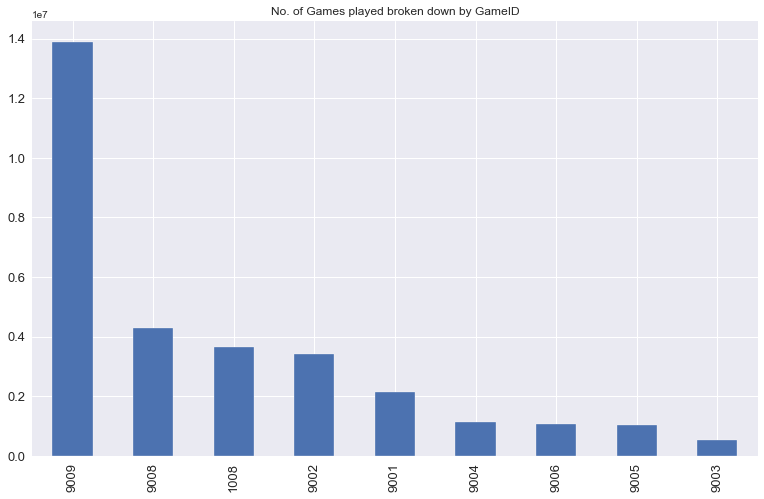

In [20]:
# Visualize the popularity of each GameID
fig=play_log_df[gameid].sum().sort_values(ascending=False).plot(kind='bar', figsize=(13,8), fontsize=13, title='No. of Games played broken down by GameID').get_figure()
fig.savefig('No. of Games played broken down by GameID.png', dpi=400)

### Popularity of betting level

100 chips per match seems to be the go-to playground while 1000 is the second most popular betting level. In general, the bigger table generate less matches. 

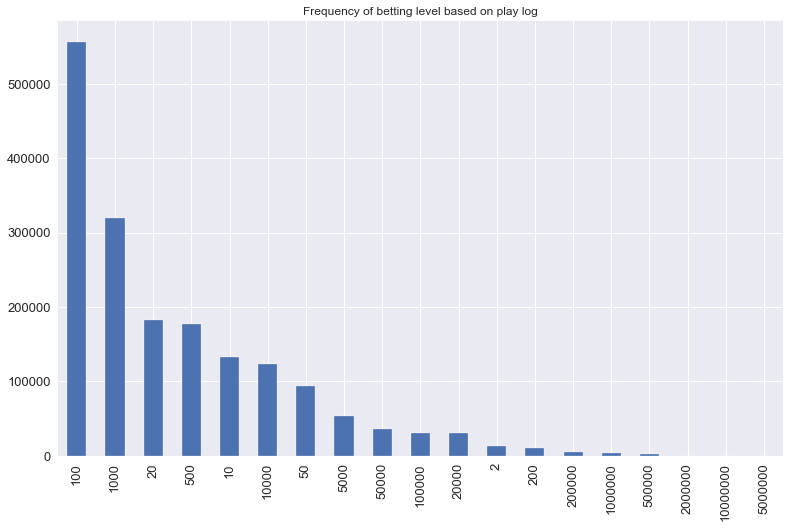

In [21]:
# Visualize the betting level based on each log
fig=play_log_df['Level'].value_counts().plot(kind='bar', figsize=(13,8), fontsize=13, title='Frequency of betting level based on play log').get_figure()
fig.savefig('Betting Level Popularity.png', dpi=400)

### Create other features from play log dataframe

I will create new features from the existing data frame namely the number of matches for each GameID and betting level that each unique user play. 

In [22]:
# Get a list of columns to aggregate later
features_list=list(play_log_df.columns)
columns_not_aggregated=['UserID', 'GameID', 'Level','Match_Length', 'Date', 'Day']

for e in columns_not_aggregated:
    features_list.remove(e)

In [23]:
# Aggregates the attributes of unique users 
player_details=play_log_df.groupby(['UserID']).sum()[features_list].reset_index()
player_details.head()

,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,200000,10,20000,500000,50,2,200,10000000,5000000,2000000
0,123,0,1,0,5700,1,75,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1406,0,2,0,7000,2,150,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1980,0,3,0,417197,3,60,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3286,7,12,2998314,2048800,19,1425,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3452,15,36,13159123,18979771,51,2725,0,0,2,...,0,0,0,0,0,0,0,0,0,0


### Merge with total spending for each player

In [24]:
# Slice transactions that corresponds with the play log
transactions_df_01_13_05_2020=transactions_df.loc[(transactions_df['Date']>='2020-05-01') & (transactions_df['Date']<='2020-05-13')]

# Sum in-game purchase by users during t0 -> t4
transactions_df_01_13_05_2020=pd.DataFrame(transactions_df_01_13_05_2020.groupby(['UserID']).sum()['Amount'])
transactions_df_01_13_05_2020.reset_index(level='UserID')
transactions_df_01_13_05_2020

# Merge transactions records with play log and fill in 0 for users that did not make any purchase in the period
player_details=player_details.merge(transactions_df_01_13_05_2020, on='UserID', how='left')
player_details=player_details.fillna(0)

# Create Winning Rate and Losing Rate for all unique users
player_details['WinningRate']=player_details['WinNo']/player_details['Games_Played']
player_details['LosingRate']=player_details['LostNo']/player_details['Games_Played']


In [25]:
# Average Revenue Per Paying User for the period and estimation of the month
ARPU12=player_details['Amount'].sum()/len(player_details)
ARPU30=ARPU12/12*30
ARPU30

0.609197995143

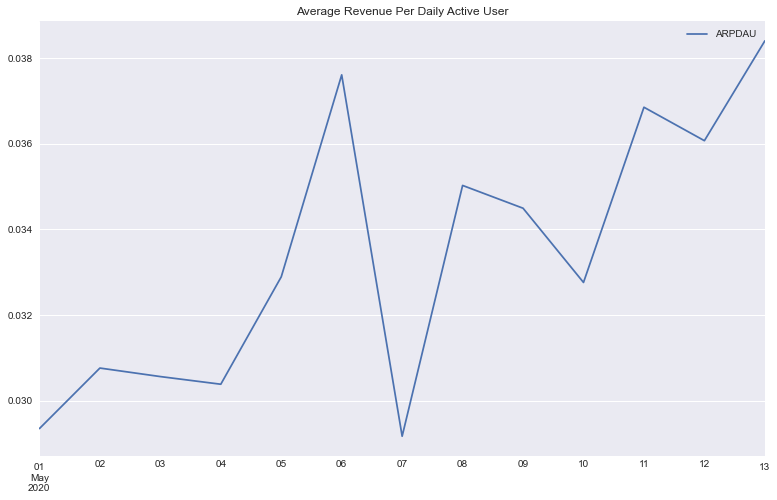

In [26]:
# Average Revenue Per Daily Active User
t0=play_log_df['Date'].min()
t_value=[]
ARPDAU_list=[]

# Get the date
for i in range(0,13):
    t_value.append(t0+datetime.timedelta(days=i))

# Make a list of ARPDAU
for t in t_value:
    ARPDAU=transactions_df.loc[(transactions_df['Date']==t)].sum()['Amount']/len(play_log_df.loc[(play_log_df['Date']==t)])
    ARPDAU_list.append(ARPDAU)

# Create a dataframe for ARPDAU from 2020-05-01 to 2020-05-13
ARPDAU_df=pd.DataFrame(ARPDAU_list, index=t_value, columns=['ARPDAU'])
fig=ARPDAU_df.plot(kind='line', figsize=(13,8), title='Average Revenue Per Daily Active User').get_figure()
fig.savefig('ARPDAU.png', dpi=400)

According to Appannie, Virtual Currency Poker and Casino Games has a benchmark ARPU: USD 0.25 - USD 1.25. Given that Lengbear operates only in Cambodia, a country of GDP on the lower end, an ARPU30 can be estimated at around $0.60 which can be considered a highly performing game. 

In [27]:
# Number of paying user
Percent_Paying_User=(np.sum(player_details['Amount']>0))/len(player_details)
Percent_Paying_User

0.07396788753604482

Conversion rate is at around 7.4% which is also considered high by mobile gaming in social casino genre. 

In [28]:
top_paying_user=player_details.sort_values(by='Amount', ascending=False).head(10)
top_paying_user

,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,500000,50,2,200,10000000,5000000,2000000,Amount,WinningRate,LosingRate
3534,1455403,1273,1483,17241461327,20446823182,2756,227370,1497,1,0,...,11,0,0,0,1,1,3,3232.0,0.461901,0.538099
9550,2484034,891,1200,7260573361,9420543000,2091,250920,2091,0,0,...,6,0,0,0,0,0,0,1150.0,0.426112,0.573888
126,812923,42,58,1557567236,2377740853,100,7500,0,0,0,...,1,0,0,0,0,2,1,378.0,0.420000,0.580000
636,888395,2991,3475,1787991727,2165565027,6466,503580,414,0,0,...,4,0,0,0,0,0,0,309.0,0.462573,0.537427
72462,5756306,268,588,2105186543,2690577375,856,102720,856,0,0,...,5,0,0,0,0,0,0,260.0,0.313084,0.686916
39987,5059628,41,76,285926770,607681770,117,10980,49,0,0,...,5,0,0,0,0,1,0,247.0,0.350427,0.649573
10092,2561168,590,1322,1339371177,1788458818,1912,182575,1280,26,0,...,0,0,0,0,0,0,0,231.0,0.308577,0.691423
40106,5065165,3472,14287,2711394399,3052283591,17759,479595,1171,0,0,...,9,0,0,0,0,0,1,223.0,0.195507,0.804493
55739,5494919,1272,1884,2751406904,3201019490,3156,315050,1757,7,355,...,23,0,0,0,0,0,3,220.5,0.403042,0.596958
52197,5419762,1551,2794,1886796976,2132829904,4345,488910,3634,0,474,...,4,0,0,0,0,0,0,219.0,0.356962,0.643038


# First Feature Engineering Method

I decided to summing up all users generated data from t0 to t4 and make them features. Features include number of winning/ losing matches in the period, the total chips won/ lost, the 

In [29]:
# Getting t0 and list of days on which user data can be extracted
t0=play_log_df['Date'].min()
t_value=[]

for i in range(0,9):
    t_value.append(t0+datetime.timedelta(days=i))
    
print(f'The data set can have t0 can start from: {t_value[0]}, to: {t_value[-1]}, pass t_value[number] to function get_data to get the desired player data')

The data set can have t0 can start from: 2020-05-01 00:00:00, to: 2020-05-09 00:00:00, pass t_value[number] to function get_data to get the desired player data


## Create a function to get data from play log

In [30]:
def get_data_sum(t0):

    ''' Generate player data from a given play log by summing up player attributes from t0 to t4
    
    Parameters
    ----------
    t0: A numeric input from range of play log
    
    Returns
    -------
    ret: a data frame of all user generated data including active session, winning rate, number of matches he/she plays, the amount of money user spent
    
    Examples
    --------
    >>>> t0=t_value[0] or t0='2020-05-01'
    >>>> get_data(t_value[0]) or get_data('YYYY-MM-DD')
    >>>> return play log dataframe
    
    '''

    # Pass in t0, t4 and tchurn
    t0=t0
    t4=t0+datetime.timedelta(days=3)
    tchurn=t0+datetime.timedelta(days=4)
    print(f't0={t0} \nt4={t4} \ntchurn={tchurn}')
    
    # Get unique users on t0
    play_log_t0=play_log_df.loc[play_log_df['Date']==t0]
    t0_users=pd.DataFrame(play_log_t0['UserID'].unique(), columns=['UserID'])

    # Slice out the dataframe that contains user playlog from t0 -> t4
    play_log_t0_t4=play_log_df.loc[(play_log_df['Date']>=t0) & (play_log_df['Date']<=t4)]
    
    # Aggregates the attributes of unique users  
    play_log_t0_t4=play_log_t0_t4.groupby(['UserID']).sum()[features_list].reset_index()
    t0_users=t0_users.merge(play_log_t0_t4, on='UserID', how='left')
        
    # Slice out transaction log for t0 -> t4
    transactions_df_t0_t4=transactions_df.loc[(transactions_df['Date']>=t0) & (transactions_df['Date']<=t4)]
    
    # Sum in-game purchase by users during t0 -> t4
    transactions_df_t0_t4=pd.DataFrame(transactions_df_t0_t4.groupby(['UserID']).sum()['Amount'])
    transactions_df_t0_t4.reset_index(level='UserID')
    
    # Merge transactions records with play log
    t0_users=t0_users.merge(transactions_df_t0_t4, on='UserID', how='left')
    
    # Create new features namely: Winning Rate, Drawing Rate, Losing Rate for all unique users
    t0_users['WinningRate']=t0_users['WinNo']/t0_users['Games_Played']
    t0_users['LosingRate']=t0_users['LostNo']/t0_users['Games_Played']
    t0_users=t0_users.fillna(0)
    
    # Slice out tchurn
    play_log_tchurn=play_log_df.loc[play_log_df['Date']==tchurn]
    
    # Getting target 
    final_play_log=t0_users.assign(Churn=t0_users.UserID.isin(play_log_tchurn.UserID).astype(int))

    return final_play_log

## Get the train data set

Passing the date t0 to get the train data set from t0 to t4

In [31]:
# Get the train data set
play_log_train=get_data_sum(t_value[0])
play_log_train.head()

t0=2020-05-01 00:00:00 
t4=2020-05-04 00:00:00 
tchurn=2020-05-05 00:00:00


,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,50,2,200,10000000,5000000,2000000,Amount,WinningRate,LosingRate,Churn
0,4775802,121,242,1900393,3498025,363,36915,219,3,0,...,0,0,0,0,0,0,1.0,0.333333,0.666667,1
1,5929933,54,83,16227,17191,137,15375,117,0,0,...,1,0,0,0,0,0,0.0,0.394161,0.605839,1
2,5728479,22,24,26826,38826,46,4665,27,0,0,...,1,0,0,0,0,0,0.0,0.478261,0.521739,1
3,5725542,239,442,57603571,68753371,681,81620,680,1,0,...,1,0,0,0,0,0,7.5,0.350954,0.649046,0
4,5942114,67,98,852087,745800,165,19350,155,0,0,...,1,0,0,0,0,0,0.0,0.406061,0.593939,0


In [32]:
# Assigning X_train and y_train
X_train=play_log_train.iloc[:,:-1]
X_train=X_train.drop(['UserID'], axis=1)

# Fill na for some value of 
X_train=X_train.fillna(0) 
X_train.shape

(56163, 37)

In [33]:
y_train=play_log_train.iloc[:,-1]

print(f' Percent of actual churn: {round(y_train.value_counts()[0]/len(y_train)*100, 2)}%')
print(f' Percent of actual stay: {round(y_train.value_counts()[1]/len(y_train)*100, 2)}%')

 Percent of actual churn: 57.0%
 Percent of actual stay: 43.0%


## Get the test data set

Call the function get_dat with t > t-churn to get the completely new data for test set

In [34]:
# Get a new set of users as the test set 
play_log_test=get_data_sum(t_value[6])
play_log_test.head()

t0=2020-05-07 00:00:00 
t4=2020-05-10 00:00:00 
tchurn=2020-05-11 00:00:00


,UserID,WinNo,LostNo,WinAmt,LostAmt,Games_Played,Active_Time,9009,9005,9001,...,50,2,200,10000000,5000000,2000000,Amount,WinningRate,LosingRate,Churn
0,5867057,25,43,87458,90083,68,8160,68,0,0,...,0,0,0,0,0,0,0.0,0.367647,0.632353,0
1,6025400,55,127,90447,120540,182,21840,182,0,0,...,0,0,0,0,0,0,0.0,0.302198,0.697802,0
2,5480199,2,4,34780,25000,6,720,6,0,0,...,0,0,0,0,0,0,0.0,0.333333,0.666667,0
3,5984362,72,82,24831235,27602195,154,13115,36,0,0,...,0,0,0,0,0,0,1.5,0.467532,0.532468,0
4,2540633,3,1,5593,2100,4,480,4,0,0,...,0,0,0,0,0,0,0.0,0.750000,0.250000,0


In [35]:
# Assigning X_test and y_test
X_test=play_log_test.iloc[:,:-1]
X_test=X_test.drop(['UserID'], axis=1)
X_test.shape

(53834, 37)

In [36]:
y_test=play_log_test.iloc[:,-1]
print(f' Percent of actual churn: {round(y_test.value_counts()[0]/len(y_test)*100, 2)}%')
print(f' Percent of actual stay: {round(y_test.value_counts()[1]/len(y_test)*100, 2)}%')

 Percent of actual churn: 52.78%
 Percent of actual stay: 47.22%


# Modelling First Attemp

I will run the data through three models namely: Logistic Regression Model, Random Forrest and Multi-layer Perception Classifier

## Logistic Regression Model

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Instantiate model
churn_logistic_regression=LogisticRegression(random_state=42, max_iter=10000)

# 2. Scale data
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# 3. Fit model
churn_logistic_regression.fit(X_train, y_train)

# 4. Score model
print(f'Score on train data: {churn_logistic_regression.score(X_train, y_train)}')
print(f'Score on test data: {churn_logistic_regression.score(X_test, y_test)}')

Score on train data: 0.7541085768210387
Score on test data: 0.7346286733291228


## Random Forrest

In [38]:
from sklearn.ensemble import RandomForestClassifier

# 1. Instantiate the model 
RF=RandomForestClassifier(random_state=42)

# 2. Fit model
RF.fit(X_train, y_train)

# 3. Score model
print(f' Accuracy on train data: {RF.score(X_train, y_train)}')
print(f' Accuracy on test data: {RF.score(X_test, y_test)}')

 Accuracy on train data: 0.9970621227498531
 Accuracy on test data: 0.7539101682951295


## Multi-layer Perceptron classifier

In [39]:
from sklearn.neural_network import MLPClassifier

In [40]:
# 1. Instantiate the model
MLP_model = MLPClassifier(hidden_layer_sizes=(10), 
                             activation='tanh',
                             max_iter=2000,
                             solver = 'lbfgs')

In [41]:
# 2. Fit the model
MLP_model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [42]:
# 3. Score the model
print(f' Accuracy on training data: {MLP_model.score(X_train, y_train)}')
print(f' Accuracy on testing data: {MLP_model.score(X_test, y_test)}')

 Accuracy on training data: 0.7799975072556665
 Accuracy on testing data: 0.7569379945759186


## Summary of the first modelling attempt

The accuracy on the test data four models I got were pretty decent. However, It was below 80%, I want higher accuracy so I will proceed with another method of feature engineering.

# Second feature engineering method

Instead of summing the different users attributes such as the number of games for each categories they play from t0 to t4, I will make each day attributes into features. I would end up having a lot more features, hopefully, this method would increase my accuracy.

In [43]:
def get_data(t0):

    ''' Generate player data from a given play log by making each day attributes into features
    
    Parameters
    ----------
    t0: A numeric input from range of play log
    
    Returns
    -------
    ret: a data frame of all user generated data including active session, winning rate, number of matches he/she plays, the amount of money user spent
    
    Examples
    --------
    >>>> t0=t_value[0] or t0='2020-05-01'
    >>>> get_data(t_value[0]) or get_data('YYYY-MM-DD')
    >>>> return play log dataframe
    
    '''

    # Pass in t0, t4 and tchurn
    t0=t0
    t0_t4_list=[]
    for i in range(0,4):
        t0_t4_list.append(t0+datetime.timedelta(days=i))    
    
    tchurn=t0+datetime.timedelta(days=4)
    print(f't0={t0} \ntchurn={tchurn}')
    
    # Get unique users on t0
    play_log_t0=play_log_df.loc[play_log_df['Date']==t0]
    t0_users=pd.DataFrame(play_log_t0['UserID'].unique(), columns=['UserID'])
    
    for t in t0_t4_list:
        
        play_log=play_log_df.loc[(play_log_df['Date']==t)]
        play_log=play_log.groupby(['UserID']).sum()[features_list].reset_index()
        play_log['WinningRate']=play_log['WinNo']/play_log['Games_Played']
        play_log['LosingRate']=play_log['LostNo']/play_log['Games_Played']
        
        transactions_log=transactions_df.loc[(transactions_df['Date']==t)]
        transactions_log=transactions_log.groupby(['UserID']).sum()['Amount'].reset_index()
        
        # Merge with unique users ID on t0
       
        t0_users=t0_users.merge(play_log, on='UserID', how='left').merge(transactions_log, on='UserID', how='left')
        t0_users=t0_users.fillna(0)
    
    # Slice out tchurn
    play_log_tchurn=play_log_df.loc[play_log_df['Date']==tchurn]

    # Getting target 
    final_play_log=t0_users.assign(Churn=t0_users.UserID.isin(play_log_tchurn.UserID).astype(int))

    return final_play_log

## Get the train data set

Passing the date t0 to get the train data set from t0 to t4

In [44]:
# Get the train data set
play_log_train=get_data(t_value[0])
play_log_train.head()

t0=2020-05-01 00:00:00 
tchurn=2020-05-05 00:00:00


,UserID,WinNo_x,LostNo_x,WinAmt_x,LostAmt_x,Games_Played_x,Active_Time_x,9009_x,9005_x,9001_x,...,50_y,2_y,200_y,10000000_y,5000000_y,2000000_y,WinningRate_y,LosingRate_y,Amount_y,Churn
0,4775802,72,137,916575,1526575,209,20300,104,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.307692,0.692308,0.0,1
1,5929933,1,2,247,140,3,360,3,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.401869,0.598131,0.0,1
2,5728479,13,14,5558,7958,27,3150,25,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.538462,0.461538,0.0,1
3,5725542,0,3,0,20000,3,360,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.411960,0.588040,0.0,0
4,5942114,54,75,634997,626700,129,15210,123,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0


In [45]:
# Assigning X_train and y_train
X_train=play_log_train.iloc[:,:-1]
X_train=X_train.drop(['UserID'], axis=1)

# Fill na for some value of 
X_train=X_train.fillna(0) 
X_train.shape

(56163, 148)

In [46]:
y_train=play_log_train.iloc[:,-1]

print(f' Percent of actual churn: {round(y_train.value_counts()[0]/len(y_train)*100, 2)}%')
print(f' Percent of actual stay: {round(y_train.value_counts()[1]/len(y_train)*100, 2)}%')

 Percent of actual churn: 57.0%
 Percent of actual stay: 43.0%


## Get the test data set

Call the function get_data with t > t-churn to get the completely new data for test set

In [47]:
# Get a new set of users as the test set 
play_log_test=get_data(t_value[6])
play_log_test.head()

t0=2020-05-07 00:00:00 
tchurn=2020-05-11 00:00:00


,UserID,WinNo_x,LostNo_x,WinAmt_x,LostAmt_x,Games_Played_x,Active_Time_x,9009_x,9005_x,9001_x,...,50_y,2_y,200_y,10000000_y,5000000_y,2000000_y,WinningRate_y,LosingRate_y,Amount_y,Churn
0,5867057,0,6,0,2360,6,720,6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6025400,0,4,0,5200,4,480,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5480199,2,2,34780,5000,4,480,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,5984362,18,16,3438745,4616905,34,3045,11,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2540633,3,1,5593,2100,4,480,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [48]:
# Assigning X_test
X_test=play_log_test.iloc[:,:-1]
X_test=X_test.drop(['UserID'], axis=1)
X_test.shape

(53834, 148)

In [49]:
# Assigning y_test
y_test=play_log_test.iloc[:,-1]
print(f' Percent of actual churn: {round(y_test.value_counts()[0]/len(y_test)*100, 2)}%')
print(f' Percent of actual stay: {round(y_test.value_counts()[1]/len(y_test)*100, 2)}%')

 Percent of actual churn: 52.78%
 Percent of actual stay: 47.22%


# Modelling second attempt

I will fit the new data into the four models again

## Logistic Regression Model

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# 1. Instantiate model
churn_logistic_regression=LogisticRegression(random_state=42, max_iter=10000)

# 2. Scale data
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)

# 3. Fit model
churn_logistic_regression.fit(X_train, y_train)

# 4. Score model
X_test=scaler.transform(X_test)

print(f'Score on train data: {churn_logistic_regression.score(X_train, y_train)}')
print(f'Score on test data: {churn_logistic_regression.score(X_test, y_test)}')

Score on train data: 0.812848316507309
Score on test data: 0.7979901177694394


### Hyperparameter tuning for Logistic Regression

In [51]:
from sklearn.model_selection import RandomizedSearchCV

max_iter=list(range(100,10000,100))
C = [0.001,0.01,0.1,1,10]
param_grid = dict(max_iter=max_iter,C=C)

In [52]:
# 1. Instantiate the Randomized Search 
random = RandomizedSearchCV(estimator=LogisticRegression(),
                            param_distributions=param_grid,
                            n_jobs=-1,
                            random_state=42)

# 2. Fit in the data
random_result = random.fit(X_train, y_train)

# 3. Summarize the best result
print(f'Best accuracy: {random_result.best_score_}, using the parameter: {random_result.best_params_}')

Best accuracy: 0.8116377568839066, using the parameter: {'max_iter': 7700, 'C': 0.01}


### New Logistic Regression with optimized parameter

In [71]:
# 1. Instantiate the model
LR=LogisticRegression(random_state=42, max_iter=7700, C=0.01)

# 2. Scale data
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)

# 3. Fit model
LR.fit(X_train, y_train)

# 4. Score model
X_test=scaler.transform(X_test)

print(f'Score on train: {LR.score(X_train, y_train)}')
print(f'Score on test: {LR.score(X_test, y_test)}')

# 5. Make classification report
y_train_pred_LR=LR.predict(X_train)
y_test_pred_LR=LR.predict(X_test)
classification_report_LR=classification_report(y_test, y_test_pred_LR)

print('=====================================================')
print(f'Classification report for Logistic Regression model: \n {classification_report(y_test, y_test_pred_LR)}')

Score on train: 0.8127414846073038
Score on test: 0.7981944496043393
Classification report for Logistic Regression model: 
               precision    recall  f1-score   support

           0       0.80      0.83      0.81     28416
           1       0.80      0.77      0.78     25418

    accuracy                           0.80     53834
   macro avg       0.80      0.80      0.80     53834
weighted avg       0.80      0.80      0.80     53834



In [54]:
# Get a dataframe of users and their probility of leaving or staying
scores = churn_logistic_regression.predict_proba(X_test)
score_LR = pd.DataFrame(scores, columns={'stay', 'churn'})

# Display 1000 users that are most likely to leave the game
score_LR.nlargest(1000, ['churn'])

,stay,churn
11965,0.000016,0.999984
10980,0.000095,0.999905
7978,0.000100,0.999900
41274,0.000137,0.999863
28523,0.000231,0.999769
...,...,...
40456,0.042889,0.957111
18105,0.042893,0.957107
53721,0.042896,0.957104
36173,0.042908,0.957092


## Random Forrest

I will pass the data through  a range of number of tree from 1 - 100 with max depth of 3 to check which one would give the highest accuracy score on test data set. 

In [55]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)

print(f' Accuracy on train data: {RF.score(X_train, y_train)}')
print(f' Accuracy on test data: {RF.score(X_test, y_test)}')

 Accuracy on train data: 0.9974360343998718
 Accuracy on test data: 0.7951480477021956


### hyperparameter tuning

Run a gridsearch to find the parameters that returns the best accuracy score

In [56]:
from sklearn.model_selection import GridSearchCV

# Make lists of max_depth and n_estimators dictionary to feed in Grid Search
max_depth=list(range(1,15,1))
n_estimators=list(range(5,100,5))
param_grid=dict(max_depth=max_depth, n_estimators=n_estimators)

# Initiate the RandomForest grid search
gs_rfmodel=GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

# Fit the RandomForest grid search
gs_rfmodel_fitted = gs_rfmodel.fit(X_train, y_train)

# Summarize the result
# Show the best estimators
print(gs_rfmodel_fitted.best_params_)

{'max_depth': 7, 'n_estimators': 75}


### New Random Forest classification model with optimized parameters

In [72]:
# 1. Recreate the RandomForest Classifier with tuned parameter
RF=RandomForestClassifier(n_estimators=75, max_depth=7,random_state=42)

# 2. Fit in trainning data
RF.fit(X_train, y_train)

# 3. Score the model
print(f' Accuracy on train data: {RF.score(X_train, y_train)}')
print(f' Accuracy on test data: {RF.score(X_test, y_test)}')

#4. Get classification report for Random Forest Classifier
y_train_pred_RF=RF.predict(X_train)
y_test_pred_RF=RF.predict(X_test)

classification_report_RF=classification_report(y_test, y_test_pred_RF)

print('=====================================================')
print(f'Classification report for Random Forest Classifier: \n {classification_report_RF}')

 Accuracy on train data: 0.8177981945408899
 Accuracy on test data: 0.7997548017981202
Classification report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81     28416
           1       0.79      0.79      0.79     25418

    accuracy                           0.80     53834
   macro avg       0.80      0.80      0.80     53834
weighted avg       0.80      0.80      0.80     53834



In [58]:
# Create a data frame containing probability that a user is going to leave the game or not
scores_RF = RF.predict_proba(X_test)
score_RF = pd.DataFrame(scores_RF, columns={'stay', 'churn'})

# Display 1000 users that are likely to leave the game
score_RF.nlargest(1000, ['churn'])

,stay,churn
27088,0.073377,0.926623
13707,0.074554,0.925446
36180,0.074617,0.925383
12486,0.075199,0.924801
11284,0.075254,0.924746
...,...,...
39035,0.083865,0.916135
42520,0.083869,0.916131
13232,0.083870,0.916130
18088,0.083879,0.916121


## Multi-layer Perceptron classifier

In [59]:
from sklearn.neural_network import MLPClassifier

In [60]:
# 1. Instantiate the model
MLP_model = MLPClassifier(hidden_layer_sizes=(10), 
                             activation='tanh',
                             max_iter=2000,
                             solver = 'lbfgs')

In [61]:
# 2. Fit the model
MLP_model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [69]:
# 3. Score the model
print(f' Accuracy on training data: {MLP_model.score(X_train, y_train)}')
print(f' Accuracy on testing data: {MLP_model.score(X_test, y_test)}')

y_train_pred_MLPC=MLP_model.predict(X_train)
y_test_pred_MLPC=MLP_model.predict(X_test)

# 4. Make classification report
classification_report_MLPC=classification_report(y_test, y_test_pred_MLPC)

print('===========================================================')
print(f'Classification report for Multilayer Perceptron Classifier: \n {classification_report_MLPC}')

 Accuracy on training data: 0.8313480405249007
 Accuracy on testing data: 0.7777984173570606
Classification report for Multilayer Perceptron Classifier: 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     28416
           1       0.77      0.75      0.76     25418

    accuracy                           0.78     53834
   macro avg       0.78      0.78      0.78     53834
weighted avg       0.78      0.78      0.78     53834



In [63]:
# Create a data frame containing probability that a user is going to leave the game or not
scores_MLP=MLP_model.predict_proba(X_test)
scores_MLP=pd.DataFrame(scores_MLP, columns={'stay', 'churn'})

# Display 1000 users that are likely to leave the game
scores_MLP.nlargest(1000, ['churn'])

,stay,churn
109,0.009522,0.990478
780,0.009522,0.990478
814,0.009522,0.990478
831,0.009522,0.990478
913,0.009522,0.990478
...,...,...
5695,0.023491,0.976509
5704,0.023491,0.976509
5719,0.023491,0.976509
5856,0.023491,0.976509


# Conclusion

In [65]:
from sklearn.metrics import plot_roc_curve

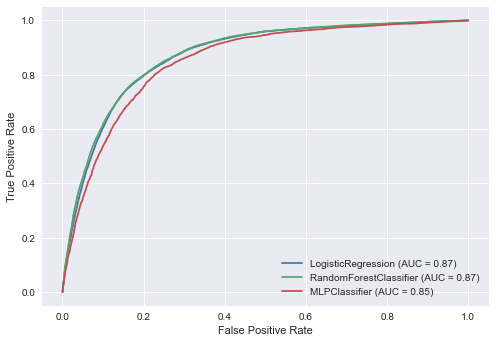

In [74]:
disp=plot_roc_curve(LR,X_test, y_test)
plot_roc_curve(RF,X_test, y_test,ax=disp.ax_);
plot_roc_curve(MLP_model,X_test, y_test,ax=disp.ax_);


In [73]:
print('01. Logistic Regression Classifier : \n',classification_report_LR)
print('02. Random Forest Classifier : \n',classification_report_RF)
print('03. Multi-layer Percepton Classifier : \n',classification_report_MPLC)

01. Logistic Regression Classifier : 
               precision    recall  f1-score   support

           0       0.80      0.83      0.81     28416
           1       0.80      0.77      0.78     25418

    accuracy                           0.80     53834
   macro avg       0.80      0.80      0.80     53834
weighted avg       0.80      0.80      0.80     53834

02. Random Forest Classifier : 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81     28416
           1       0.79      0.79      0.79     25418

    accuracy                           0.80     53834
   macro avg       0.80      0.80      0.80     53834
weighted avg       0.80      0.80      0.80     53834

03. Multi-layer Percepton Classifier : 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     28416
           1       0.77      0.75      0.76     25418

    accuracy                           0.78     53834
   macro avg   

Accuracy is highest in Random Forest Classifier and Logistic Regression Classifier. The company can choose Logistic Regression Classifier for its quickest run time. After running the models, we can get the list of users who are highly likely to churn we can approach these users in a few way to improve the chance of them staying in the game.

Firstly, the company can segment the users into multiple groups based on their chances of leaving. For example: 0-20%, 21-40%, 41-60%, 61-80% and the rest.

Secondly, the company can deploy A/B testing on each of the segment to check how they respond to certain promotion packages and choose the best ones that work. 

Thirdly, the company can also 